In [1]:
import os

import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
np.random.seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### 1. Read raw sleep data

In [3]:
raw_data_folder = Path("./data/raw_data/")
images_folder = Path("./data/processed_data/images/")
processed_data_folder = Path("./data/processed_data/")

In [4]:
def get_all_images()    :
    image_names = []
    for file_path in images_folder.glob("*.jpg"):
        file_name = str(file_path).split("/")[-1]
        image_names.append(file_name)
    return image_names

In [5]:
images_names = get_all_images()
annotations_df = pd.read_csv(processed_data_folder/"annotations_cutoff.csv")
annotations_df['image_name'] = annotations_df["image_name"].apply(lambda x: x.replace(":", "_"))
one_day_properties = pd.read_csv(processed_data_folder/"one_day_properties.csv")
one_day_properties['image_name'] = one_day_properties["image_name"].apply(lambda x: x.replace(":", "_"))

In [6]:
images_names[:5]

['data\\processed_data\\images\\038441c925bb_2018-08-14T20_30_00.jpg',
 'data\\processed_data\\images\\038441c925bb_2018-08-15T20_30_00.jpg',
 'data\\processed_data\\images\\038441c925bb_2018-08-16T20_30_00.jpg',
 'data\\processed_data\\images\\038441c925bb_2018-08-17T20_30_00.jpg',
 'data\\processed_data\\images\\038441c925bb_2018-08-18T20_30_00.jpg']

In [7]:
one_day_properties

,series_id,image_name,idx_in_series,num_steps_window,num_steps_cumulative
0,038441c925bb,038441c925bb_2018-08-14T20_30_00.jpg,0,720.0,720.0
1,038441c925bb,038441c925bb_2018-08-15T20_30_00.jpg,1,17280.0,18000.0
2,038441c925bb,038441c925bb_2018-08-16T20_30_00.jpg,2,17280.0,35280.0
3,038441c925bb,038441c925bb_2018-08-17T20_30_00.jpg,3,17280.0,52560.0
4,038441c925bb,038441c925bb_2018-08-18T20_30_00.jpg,4,17280.0,69840.0
...,...,...,...,...,...
7691,fe90110788d2,fe90110788d2_2017-09-04T20_30_00.jpg,30,17280.0,534960.0
7692,fe90110788d2,fe90110788d2_2017-09-05T20_30_00.jpg,31,17280.0,552240.0
7693,fe90110788d2,fe90110788d2_2017-09-06T20_30_00.jpg,32,17280.0,569520.0
7694,fe90110788d2,fe90110788d2_2017-09-07T20_30_00.jpg,33,17280.0,586800.0


In [8]:
annotations_df

,series_id,image_name,label,step_in_series,step_in_window,x0,y0,x1,y1
0,038441c925bb,038441c925bb_2018-08-15T20_30_00.jpg,onset,4992.0,4272.0,336,20,376,380
1,038441c925bb,038441c925bb_2018-08-15T20_30_00.jpg,wakeup,10932.0,10212.0,831,20,871,380
2,038441c925bb,038441c925bb_2018-08-16T20_30_00.jpg,onset,20244.0,2244.0,167,20,207,380
3,038441c925bb,038441c925bb_2018-08-16T20_30_00.jpg,wakeup,27492.0,9492.0,771,20,811,380
4,038441c925bb,038441c925bb_2018-08-17T20_30_00.jpg,onset,39996.0,4716.0,373,20,413,380
...,...,...,...,...,...,...,...,...,...
9580,fe90110788d2,fe90110788d2_2017-09-05T20_30_00.jpg,wakeup,547152.0,12192.0,996,20,1036,380
9581,fe90110788d2,fe90110788d2_2017-09-06T20_30_00.jpg,onset,556560.0,4320.0,340,20,380,380
9582,fe90110788d2,fe90110788d2_2017-09-06T20_30_00.jpg,wakeup,560604.0,8364.0,677,20,717,380
9583,fe90110788d2,fe90110788d2_2017-09-07T20_30_00.jpg,onset,574620.0,5100.0,405,20,445,380


### 2. Split train, valid and get all test data

In [9]:
train_events = pd.read_csv(raw_data_folder/"train_events.csv")
series_ids = train_events['series_id'].unique()
num_val_series_ids = round(0.2 * len(series_ids))
series_ids_in_val = np.random.choice(series_ids, size=num_val_series_ids, replace=False)
series_ids_in_train = series_ids[~ np.isin(series_ids, series_ids_in_val)]

In [10]:
train = one_day_properties.loc[one_day_properties['series_id'].isin(series_ids_in_train)].reset_index(drop=True)
val = one_day_properties.loc[one_day_properties['series_id'].isin(series_ids_in_val)].reset_index(drop=True)

In [11]:
train

,series_id,image_name,idx_in_series,num_steps_window,num_steps_cumulative
0,038441c925bb,038441c925bb_2018-08-14T20_30_00.jpg,0,720.0,720.0
1,038441c925bb,038441c925bb_2018-08-15T20_30_00.jpg,1,17280.0,18000.0
2,038441c925bb,038441c925bb_2018-08-16T20_30_00.jpg,2,17280.0,35280.0
3,038441c925bb,038441c925bb_2018-08-17T20_30_00.jpg,3,17280.0,52560.0
4,038441c925bb,038441c925bb_2018-08-18T20_30_00.jpg,4,17280.0,69840.0
...,...,...,...,...,...
6219,fe90110788d2,fe90110788d2_2017-09-04T20_30_00.jpg,30,17280.0,534960.0
6220,fe90110788d2,fe90110788d2_2017-09-05T20_30_00.jpg,31,17280.0,552240.0
6221,fe90110788d2,fe90110788d2_2017-09-06T20_30_00.jpg,32,17280.0,569520.0
6222,fe90110788d2,fe90110788d2_2017-09-07T20_30_00.jpg,33,17280.0,586800.0


In [12]:
val

,series_id,image_name,idx_in_series,num_steps_window,num_steps_cumulative
0,062dbd4c95e6,062dbd4c95e6_2018-08-22T20_30_00.jpg,0,3060.0,3060.0
1,062dbd4c95e6,062dbd4c95e6_2018-08-23T20_30_00.jpg,1,17280.0,20340.0
2,062dbd4c95e6,062dbd4c95e6_2018-08-24T20_30_00.jpg,2,17280.0,37620.0
3,062dbd4c95e6,062dbd4c95e6_2018-08-25T20_30_00.jpg,3,17280.0,54900.0
4,062dbd4c95e6,062dbd4c95e6_2018-08-26T20_30_00.jpg,4,17280.0,72180.0
...,...,...,...,...,...
1467,fbf33b1a2c10,fbf33b1a2c10_2018-04-19T20_30_00.jpg,21,17280.0,363060.0
1468,fbf33b1a2c10,fbf33b1a2c10_2018-04-20T20_30_00.jpg,22,17280.0,380340.0
1469,fbf33b1a2c10,fbf33b1a2c10_2018-04-21T20_30_00.jpg,23,17280.0,397620.0
1470,fbf33b1a2c10,fbf33b1a2c10_2018-04-22T20_30_00.jpg,24,17280.0,414900.0


In [13]:
val_events = train_events.loc[train_events['series_id'].isin(series_ids_in_val)]
val_events = val_events.loc[val_events['timestamp'].notna()].reset_index(drop=True)
val_events

,series_id,night,event,step,timestamp
0,062dbd4c95e6,1,onset,7872.0,2018-08-22T23:11:00-0400
1,062dbd4c95e6,1,wakeup,14484.0,2018-08-23T08:22:00-0400
2,062dbd4c95e6,4,onset,60720.0,2018-08-26T00:35:00-0400
3,062dbd4c95e6,4,wakeup,68400.0,2018-08-26T11:15:00-0400
4,062dbd4c95e6,5,onset,77304.0,2018-08-26T23:37:00-0400
...,...,...,...,...,...
1904,fbf33b1a2c10,21,wakeup,356040.0,2018-04-19T06:45:00-0400
1905,fbf33b1a2c10,23,onset,385476.0,2018-04-20T23:38:00-0400
1906,fbf33b1a2c10,23,wakeup,391224.0,2018-04-21T07:37:00-0400
1907,fbf33b1a2c10,24,onset,404316.0,2018-04-22T01:48:00-0400


In [14]:
train_events = train_events.loc[train_events['series_id'].isin(series_ids_in_train)]
train_events = train_events.loc[train_events['timestamp'].notna()].reset_index(drop=True)
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
7671,fe90110788d2,32,wakeup,547152.0,2017-09-05T09:26:00-0400
7672,fe90110788d2,33,onset,556560.0,2017-09-05T22:30:00-0400
7673,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
7674,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400


### 3. DataLoader

In [15]:
def get_transforms():
    transforms = []
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    transforms.append(T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
    res = T.Compose(transforms)
    # print(f"cur = {res}")
    return res

In [16]:
class SleepStatesDataset(torch.utils.data.Dataset):
    def __init__(self, split_df, annotations_df, images_folder, transforms):
        self.label_mapping = {'onset': 1, 'wakeup': 2}
        self.split_df = split_df
        self.annotations_df = annotations_df
        self.images_folder = images_folder
        self.transforms = transforms
    
    def __len__(self):
        return len(self.split_df)
    
    def __getitem__(self, idx):
        image_name = self.split_df['image_name'][idx]
        # print(f"image_name = {image_name}")
        image_path = os.path.join(self.images_folder, image_name)
        # print(f"image_path = {image_path}")
        image = read_image(image_path)
        window_df = self.annotations_df.loc[self.annotations_df['image_name'] == image_name]
        if len(window_df) > 0:            
            boxes = torch.tensor(window_df.iloc[:, 5:].values, dtype=torch.float32)
            labels = window_df['label']
            labels = torch.tensor([self.label_mapping[l] for l in labels], dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros(size=(len(window_df),), dtype=torch.int64)
        else:
            boxes = torch.empty(size=(0, 4), dtype=torch.float32)
            labels = torch.empty(size=(0,), dtype=torch.int64)
            area = torch.empty(size=(0,), dtype=torch.float32)
            iscrowd = torch.empty(size=(0,), dtype=torch.int64)
        
        image = tv_tensors.Image(image)
        # print(f"image = {image}")
        target = {}
        target['image_id'] = image_name
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        # print(f"target={target}")
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [18]:
train_dataset = SleepStatesDataset(train, annotations_df, images_folder, get_transforms())
val_dataset = SleepStatesDataset(val, annotations_df, images_folder, get_transforms())

In [19]:
len(train_dataset), len(val_dataset)

(6224, 1472)

In [20]:
# train_dataset[0]

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
len(train_loader), len(val_loader)

(778, 184)

In [23]:
images, targets = next(iter(train_loader))
type(images), type(targets)

(tuple, tuple)

### 4. Model

In [24]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", max_size=1440)

num_classes = 3 # 2 classes ('onset' & 'wakeup') + the 'background' class

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [26]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1440, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### 5. Evaluation Metric

In [27]:
series_id_column_name = None
time_column_name = None
event_column_name = None
score_column_name = None
use_scoring_intervals = None

In [28]:
class ParticipantVisibleError(Exception):
    pass

In [29]:
def filter_detections(detections, intervals):
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)

In [30]:
def match_detections(tolerance, ground_truths, detections):
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted

In [31]:
def precision_recall_curve(matches, scores, p):
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence.
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases.
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # Total number of ground truths might be different than total number of matches.

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0.
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]

In [32]:
def average_precision_score(matches, scores, p):
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral.
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])

In [33]:
def event_detection_ap(solution, submission, tolerances):
    # Ensure solution and submission are sorted properly.
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution
            .query("event in ['start', 'end']")
            .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
            .pivot(
                index='interval',
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ['start', 'end']]
            .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation).
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event.
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals.
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values.
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths[series_id_column_name].unique()],
        columns=[event_column_name, 'tolerance', series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id.
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    # Match detections to ground truth events by evaluation group.
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group.
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby([event_column_name, 'tolerance']).apply(
            lambda group: average_precision_score(
                group['matched'].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes.
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

In [34]:
def score(solution, submission, tolerances, series_id_column_name, time_column_name, event_column_name, score_column_name, use_scoring_intervals=False):
    # Validate metric parameters.
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),\
        (f"Solution column {event_column_name} must contain the same events "
         "as defined in tolerances.")
    assert pd.api.types.is_numeric_dtype(solution[time_column_name]),\
        f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format.
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{column_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments.
    globals()['series_id_column_name'] = series_id_column_name
    globals()['time_column_name'] = time_column_name
    globals()['event_column_name'] = event_column_name
    globals()['score_column_name'] = score_column_name
    globals()['use_scoring_intervals'] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)

In [35]:
tolerances = {
    "onset" : [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]    
}

In [36]:
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score'
}

In [37]:
def get_transforms():
    transforms = []
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    transforms.append(T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
    return T.Compose(transforms)

In [38]:
eval_transforms = get_transforms()
reverse_label_mapping = {1: "onset", 2: "wakeup"}

In [39]:
def compute_metric():
    all_val_preds = []
    for i, series_id in tqdm(enumerate(series_ids_in_val)): # i is the index of the series.
        series_rows = one_day_properties.loc[one_day_properties['series_id'] == series_id].reset_index(drop=True)
        for j in range(len(series_rows)): # j is the index of the image (within the series).
            image_name = series_rows['image_name'][j]
            image_path = os.path.join(processed_data_folder, "images", image_name)
            image = read_image(image_path)
            with torch.no_grad():
                x = eval_transforms(image)
                x = x.to(device)
                predictions = model([x])
            pred = predictions[0]
            # Postprocessing: remove 'narrow' boxes as these are false positives.
            pred_widths = pred['boxes'][:, 2] - pred['boxes'][:, 0]
            pred['boxes'] = pred['boxes'][pred_widths > 10]
            pred['labels'] = pred['labels'][pred_widths > 10]
            pred['scores'] = pred['scores'][pred_widths > 10]
            if len(pred['labels']) == 0:
                continue
            else:
                pred_x = (pred['boxes'][:, 0] + pred['boxes'][:, 2]) / 2
                pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
                num_steps_window = series_rows['num_steps_window'][j]
                if j == 0:
                    prev_num_steps_cumulative = 0
                else:
                    prev_num_steps_cumulative = series_rows['num_steps_cumulative'][j - 1]            
                for k in range(len(pred_labels)): # k is the index of the bounding box (within the image).
                    event = {}
                    step_in_window = (pred_x[k] / 1440) * num_steps_window # All images have width 1,440px.
                    step_in_series = int(prev_num_steps_cumulative + step_in_window)
                    event['series_id'] = series_id
                    event['step'] = step_in_series
                    event['event'] = pred_labels[k]
                    event['score'] = pred['scores'][k].item()
                    all_val_preds.append(event)
    all_val_preds_df = pd.DataFrame(all_val_preds)
    all_val_preds_df = all_val_preds_df.sort_values(by=['series_id', 'step']).reset_index(drop=True)
    all_val_preds_df['row_id'] = np.arange(len(all_val_preds_df))
    all_val_preds_df = all_val_preds_df[['row_id', 'series_id', 'step', 'event', 'score']]
    competition_metric = round(score(val_events, all_val_preds_df, tolerances, **column_names), 4)
    return competition_metric

### 6. Train

In [40]:
from engine import train_one_epoch, evaluate

In [41]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [42]:
model_idx = "m11"
num_epochs = 10
for epoch in range(num_epochs):
    # Train for one epoch:
    print(f"epoch = epoch")
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)
    print("finish here===1")
    # Update the learning rate
    lr_scheduler.step()
    print("finish here===2")
    # Evaluate on the validation set:
    evaluate(model, val_loader, device=device)
    print("finish here===3")
    # Compute the competition metric:
    competition_metric = compute_metric()
    print("finish here===3")
    print(f"Competition metric: {competition_metric}")
    print("Saving model weights...")
    torch.save(model.state_dict(), f"{model_idx}_{epoch}.pth")
    print("Model weights saved.")
    print("---")
print("Training has been done!")

epoch = epoch


0it [00:00, ?it/s]

Epoch: [0]  [  0/778]  eta: 0:16:25  lr: 0.000011  loss: 3.5680 (3.5680)  loss_classifier: 1.1914 (1.1914)  loss_box_reg: 0.0053 (0.0053)  loss_objectness: 2.0454 (2.0454)  loss_rpn_box_reg: 0.3259 (0.3259)  time: 1.2667  data: 0.0436  max mem: 4728
Epoch: [0]  [ 25/778]  eta: 0:07:58  lr: 0.000172  loss: 0.5015 (0.8988)  loss_classifier: 0.1705 (0.3512)  loss_box_reg: 0.0704 (0.0699)  loss_objectness: 0.1708 (0.3283)  loss_rpn_box_reg: 0.0948 (0.1494)  time: 0.6086  data: 0.0497  max mem: 4886
Epoch: [0]  [ 50/778]  eta: 0:07:35  lr: 0.000333  loss: 0.2270 (0.5850)  loss_classifier: 0.0851 (0.2284)  loss_box_reg: 0.0475 (0.0625)  loss_objectness: 0.0311 (0.1853)  loss_rpn_box_reg: 0.0563 (0.1088)  time: 0.6212  data: 0.0585  max mem: 4886
Epoch: [0]  [ 75/778]  eta: 0:07:27  lr: 0.000494  loss: 0.1859 (0.4562)  loss_classifier: 0.0851 (0.1812)  loss_box_reg: 0.0538 (0.0598)  loss_objectness: 0.0226 (0.1325)  loss_rpn_box_reg: 0.0297 (0.0826)  time: 0.6500  data: 0.0718  max mem: 4886


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.6257
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [1]  [  0/778]  eta: 0:13:59  lr: 0.005000  loss: 0.0872 (0.0872)  loss_classifier: 0.0208 (0.0208)  loss_box_reg: 0.0194 (0.0194)  loss_objectness: 0.0232 (0.0232)  loss_rpn_box_reg: 0.0239 (0.0239)  time: 1.0789  data: 0.1537  max mem: 4887
Epoch: [1]  [ 25/778]  eta: 0:09:31  lr: 0.005000  loss: 0.0383 (0.0442)  loss_classifier: 0.0104 (0.0114)  loss_box_reg: 0.0098 (0.0099)  loss_objectness: 0.0115 (0.0127)  loss_rpn_box_reg: 0.0087 (0.0101)  time: 0.7495  data: 0.1623  max mem: 4887
Epoch: [1]  [ 50/778]  eta: 0:09:03  lr: 0.005000  loss: 0.0369 (0.0422)  loss_classifier: 0.0100 (0.0116)  loss_box_reg: 0.0092 (0.0100)  loss_objectness: 0.0097 (0.0115)  loss_rpn_box_reg: 0.0075 (0.0091)  time: 0.7311  data: 0.1589  max mem: 4887
Epoch: [1]  [ 75/778]  eta: 0:08:40  lr: 0.005000  loss: 0.0390 (0.0427)  loss_classifier: 0.0104 (0.0119)  loss_box_reg: 0.0108 (0.0102)  loss_objectness: 0.0095 (0.0118)  loss_rpn_box_reg: 0.0082 (0.0089)  time: 0.7232  data: 0.1552  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.6861
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [2]  [  0/778]  eta: 0:13:33  lr: 0.005000  loss: 0.0212 (0.0212)  loss_classifier: 0.0049 (0.0049)  loss_box_reg: 0.0053 (0.0053)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 1.0460  data: 0.0635  max mem: 4887
Epoch: [2]  [ 25/778]  eta: 0:07:49  lr: 0.005000  loss: 0.0278 (0.0309)  loss_classifier: 0.0077 (0.0080)  loss_box_reg: 0.0081 (0.0083)  loss_objectness: 0.0061 (0.0081)  loss_rpn_box_reg: 0.0060 (0.0065)  time: 0.6036  data: 0.0533  max mem: 4887
Epoch: [2]  [ 50/778]  eta: 0:07:25  lr: 0.005000  loss: 0.0229 (0.0285)  loss_classifier: 0.0063 (0.0075)  loss_box_reg: 0.0067 (0.0076)  loss_objectness: 0.0056 (0.0077)  loss_rpn_box_reg: 0.0046 (0.0056)  time: 0.6002  data: 0.0515  max mem: 4887
Epoch: [2]  [ 75/778]  eta: 0:07:06  lr: 0.005000  loss: 0.0276 (0.0284)  loss_classifier: 0.0073 (0.0078)  loss_box_reg: 0.0084 (0.0079)  loss_objectness: 0.0057 (0.0073)  loss_rpn_box_reg: 0.0048 (0.0054)  time: 0.5921  data: 0.0536  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.7026
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [3]  [  0/778]  eta: 0:11:49  lr: 0.000500  loss: 0.0188 (0.0188)  loss_classifier: 0.0049 (0.0049)  loss_box_reg: 0.0051 (0.0051)  loss_objectness: 0.0057 (0.0057)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.9122  data: 0.0516  max mem: 4887
Epoch: [3]  [ 25/778]  eta: 0:07:40  lr: 0.000500  loss: 0.0214 (0.0263)  loss_classifier: 0.0060 (0.0072)  loss_box_reg: 0.0080 (0.0070)  loss_objectness: 0.0055 (0.0080)  loss_rpn_box_reg: 0.0038 (0.0041)  time: 0.5986  data: 0.0564  max mem: 4887
Epoch: [3]  [ 50/778]  eta: 0:07:20  lr: 0.000500  loss: 0.0236 (0.0259)  loss_classifier: 0.0078 (0.0074)  loss_box_reg: 0.0071 (0.0072)  loss_objectness: 0.0045 (0.0073)  loss_rpn_box_reg: 0.0038 (0.0040)  time: 0.5978  data: 0.0532  max mem: 4887
Epoch: [3]  [ 75/778]  eta: 0:07:03  lr: 0.000500  loss: 0.0245 (0.0258)  loss_classifier: 0.0072 (0.0076)  loss_box_reg: 0.0065 (0.0074)  loss_objectness: 0.0044 (0.0066)  loss_rpn_box_reg: 0.0037 (0.0041)  time: 0.5952  data: 0.0562  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.7106
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [4]  [  0/778]  eta: 0:12:37  lr: 0.000500  loss: 0.0423 (0.0423)  loss_classifier: 0.0110 (0.0110)  loss_box_reg: 0.0061 (0.0061)  loss_objectness: 0.0168 (0.0168)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 0.9741  data: 0.0536  max mem: 4887
Epoch: [4]  [ 25/778]  eta: 0:07:37  lr: 0.000500  loss: 0.0214 (0.0255)  loss_classifier: 0.0067 (0.0075)  loss_box_reg: 0.0054 (0.0060)  loss_objectness: 0.0072 (0.0078)  loss_rpn_box_reg: 0.0037 (0.0042)  time: 0.5930  data: 0.0567  max mem: 4887
Epoch: [4]  [ 50/778]  eta: 0:07:16  lr: 0.000500  loss: 0.0257 (0.0262)  loss_classifier: 0.0067 (0.0075)  loss_box_reg: 0.0073 (0.0063)  loss_objectness: 0.0063 (0.0082)  loss_rpn_box_reg: 0.0040 (0.0041)  time: 0.5919  data: 0.0542  max mem: 4887
Epoch: [4]  [ 75/778]  eta: 0:07:02  lr: 0.000500  loss: 0.0225 (0.0259)  loss_classifier: 0.0072 (0.0077)  loss_box_reg: 0.0060 (0.0065)  loss_objectness: 0.0039 (0.0077)  loss_rpn_box_reg: 0.0033 (0.0041)  time: 0.6072  data: 0.0498  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.7113
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [5]  [  0/778]  eta: 0:13:53  lr: 0.000500  loss: 0.0334 (0.0334)  loss_classifier: 0.0113 (0.0113)  loss_box_reg: 0.0073 (0.0073)  loss_objectness: 0.0092 (0.0092)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 1.0707  data: 0.0522  max mem: 4887
Epoch: [5]  [ 25/778]  eta: 0:07:52  lr: 0.000500  loss: 0.0194 (0.0232)  loss_classifier: 0.0063 (0.0072)  loss_box_reg: 0.0059 (0.0065)  loss_objectness: 0.0047 (0.0057)  loss_rpn_box_reg: 0.0031 (0.0038)  time: 0.6107  data: 0.0543  max mem: 4887
Epoch: [5]  [ 50/778]  eta: 0:07:28  lr: 0.000500  loss: 0.0234 (0.0237)  loss_classifier: 0.0066 (0.0071)  loss_box_reg: 0.0065 (0.0063)  loss_objectness: 0.0052 (0.0064)  loss_rpn_box_reg: 0.0038 (0.0039)  time: 0.6057  data: 0.0546  max mem: 4887
Epoch: [5]  [ 75/778]  eta: 0:07:10  lr: 0.000500  loss: 0.0193 (0.0236)  loss_classifier: 0.0059 (0.0071)  loss_box_reg: 0.0060 (0.0062)  loss_objectness: 0.0058 (0.0063)  loss_rpn_box_reg: 0.0030 (0.0039)  time: 0.6043  data: 0.0563  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.7146
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [6]  [  0/778]  eta: 0:13:13  lr: 0.000050  loss: 0.0318 (0.0318)  loss_classifier: 0.0064 (0.0064)  loss_box_reg: 0.0106 (0.0106)  loss_objectness: 0.0089 (0.0089)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 1.0198  data: 0.0506  max mem: 4887
Epoch: [6]  [ 25/778]  eta: 0:07:48  lr: 0.000050  loss: 0.0212 (0.0282)  loss_classifier: 0.0063 (0.0084)  loss_box_reg: 0.0064 (0.0066)  loss_objectness: 0.0069 (0.0086)  loss_rpn_box_reg: 0.0041 (0.0046)  time: 0.6068  data: 0.0528  max mem: 4887
Epoch: [6]  [ 50/778]  eta: 0:07:28  lr: 0.000050  loss: 0.0219 (0.0265)  loss_classifier: 0.0068 (0.0083)  loss_box_reg: 0.0061 (0.0066)  loss_objectness: 0.0049 (0.0072)  loss_rpn_box_reg: 0.0039 (0.0044)  time: 0.6050  data: 0.0574  max mem: 4887
Epoch: [6]  [ 75/778]  eta: 0:07:13  lr: 0.000050  loss: 0.0237 (0.0259)  loss_classifier: 0.0072 (0.0080)  loss_box_reg: 0.0067 (0.0068)  loss_objectness: 0.0058 (0.0067)  loss_rpn_box_reg: 0.0034 (0.0044)  time: 0.6164  data: 0.0516  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.7122
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [7]  [  0/778]  eta: 0:12:36  lr: 0.000050  loss: 0.0217 (0.0217)  loss_classifier: 0.0049 (0.0049)  loss_box_reg: 0.0064 (0.0064)  loss_objectness: 0.0068 (0.0068)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.9719  data: 0.0561  max mem: 4887
Epoch: [7]  [ 25/778]  eta: 0:07:40  lr: 0.000050  loss: 0.0222 (0.0262)  loss_classifier: 0.0059 (0.0084)  loss_box_reg: 0.0070 (0.0072)  loss_objectness: 0.0052 (0.0062)  loss_rpn_box_reg: 0.0036 (0.0044)  time: 0.5951  data: 0.0542  max mem: 4887
Epoch: [7]  [ 50/778]  eta: 0:07:18  lr: 0.000050  loss: 0.0177 (0.0265)  loss_classifier: 0.0058 (0.0085)  loss_box_reg: 0.0060 (0.0067)  loss_objectness: 0.0051 (0.0073)  loss_rpn_box_reg: 0.0027 (0.0039)  time: 0.5917  data: 0.0556  max mem: 4887
Epoch: [7]  [ 75/778]  eta: 0:07:03  lr: 0.000050  loss: 0.0246 (0.0261)  loss_classifier: 0.0065 (0.0082)  loss_box_reg: 0.0071 (0.0068)  loss_objectness: 0.0045 (0.0070)  loss_rpn_box_reg: 0.0039 (0.0040)  time: 0.5994  data: 0.0543  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.7135
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [8]  [  0/778]  eta: 0:13:00  lr: 0.000050  loss: 0.0312 (0.0312)  loss_classifier: 0.0104 (0.0104)  loss_box_reg: 0.0051 (0.0051)  loss_objectness: 0.0096 (0.0096)  loss_rpn_box_reg: 0.0062 (0.0062)  time: 1.0035  data: 0.0542  max mem: 4887
Epoch: [8]  [ 25/778]  eta: 0:07:48  lr: 0.000050  loss: 0.0209 (0.0211)  loss_classifier: 0.0061 (0.0064)  loss_box_reg: 0.0057 (0.0058)  loss_objectness: 0.0039 (0.0055)  loss_rpn_box_reg: 0.0035 (0.0033)  time: 0.6049  data: 0.0524  max mem: 4887
Epoch: [8]  [ 50/778]  eta: 0:07:26  lr: 0.000050  loss: 0.0253 (0.0234)  loss_classifier: 0.0088 (0.0073)  loss_box_reg: 0.0068 (0.0065)  loss_objectness: 0.0039 (0.0056)  loss_rpn_box_reg: 0.0046 (0.0040)  time: 0.6014  data: 0.0527  max mem: 4887
Epoch: [8]  [ 75/778]  eta: 0:07:06  lr: 0.000050  loss: 0.0200 (0.0222)  loss_classifier: 0.0058 (0.0069)  loss_box_reg: 0.0054 (0.0063)  loss_objectness: 0.0053 (0.0054)  loss_rpn_box_reg: 0.0025 (0.0036)  time: 0.5934  data: 0.0528  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.7125
Saving model weights...
Model weights saved.
---
epoch = epoch


0it [00:00, ?it/s]

Epoch: [9]  [  0/778]  eta: 0:13:34  lr: 0.000005  loss: 0.0552 (0.0552)  loss_classifier: 0.0197 (0.0197)  loss_box_reg: 0.0094 (0.0094)  loss_objectness: 0.0175 (0.0175)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 1.0468  data: 0.0507  max mem: 4887
Epoch: [9]  [ 25/778]  eta: 0:07:52  lr: 0.000005  loss: 0.0188 (0.0236)  loss_classifier: 0.0064 (0.0074)  loss_box_reg: 0.0049 (0.0061)  loss_objectness: 0.0051 (0.0065)  loss_rpn_box_reg: 0.0027 (0.0037)  time: 0.6088  data: 0.0525  max mem: 4887
Epoch: [9]  [ 50/778]  eta: 0:07:31  lr: 0.000005  loss: 0.0215 (0.0244)  loss_classifier: 0.0068 (0.0075)  loss_box_reg: 0.0058 (0.0064)  loss_objectness: 0.0050 (0.0064)  loss_rpn_box_reg: 0.0031 (0.0040)  time: 0.6129  data: 0.0510  max mem: 4887
Epoch: [9]  [ 75/778]  eta: 0:07:14  lr: 0.000005  loss: 0.0257 (0.0246)  loss_classifier: 0.0075 (0.0078)  loss_box_reg: 0.0069 (0.0065)  loss_objectness: 0.0054 (0.0064)  loss_rpn_box_reg: 0.0036 (0.0039)  time: 0.6153  data: 0.0524  max mem: 4887


0it [00:00, ?it/s]

finish here===3
Competition metric: 0.713
Saving model weights...
Model weights saved.
---
Training has been done!


### 7. Evaluation 

In [43]:
# Examining a few validation set predictions
model.load_state_dict(torch.load("m11_0.pth"))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1440, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### 7.1 Examining a selected images that don't have any annotations

In [44]:
image_name = "ea0770830757_2018-10-21T20_30_00.jpg"
image_path = os.path.join(processed_data_folder, "images", image_name)
image = read_image(image_path)

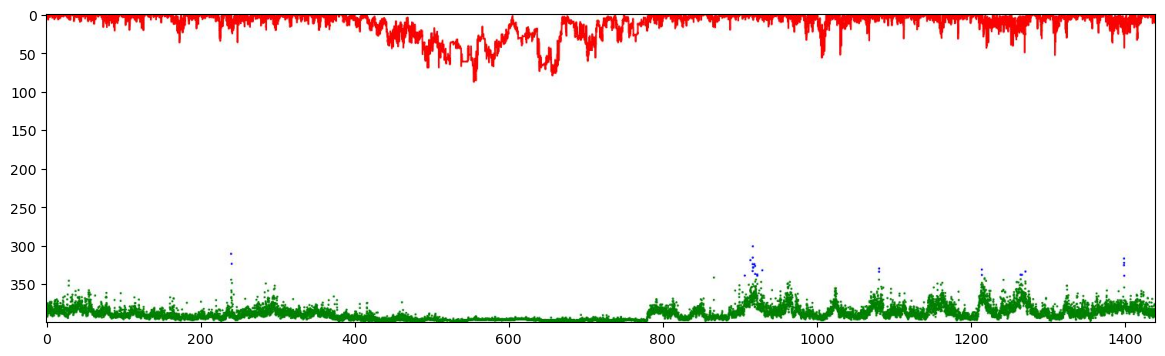

In [45]:
plt.figure(figsize=(14.4, 4))
plt.imshow(image.permute(1, 2, 0))

In [46]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0')}]

In [47]:
pred = predictions[0]
thresh = 0.7
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]

d:\Anaconda3\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


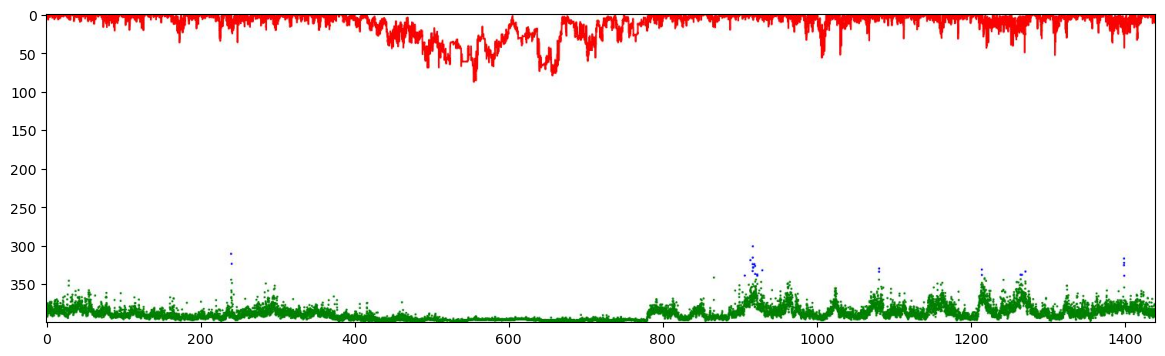

In [48]:
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="cyan", width=4)
plt.figure(figsize=(14.4, 4))
plt.imshow(output_image.permute(1, 2, 0))

#### 7.2 Examining a selected images that have exactly 2 annotations

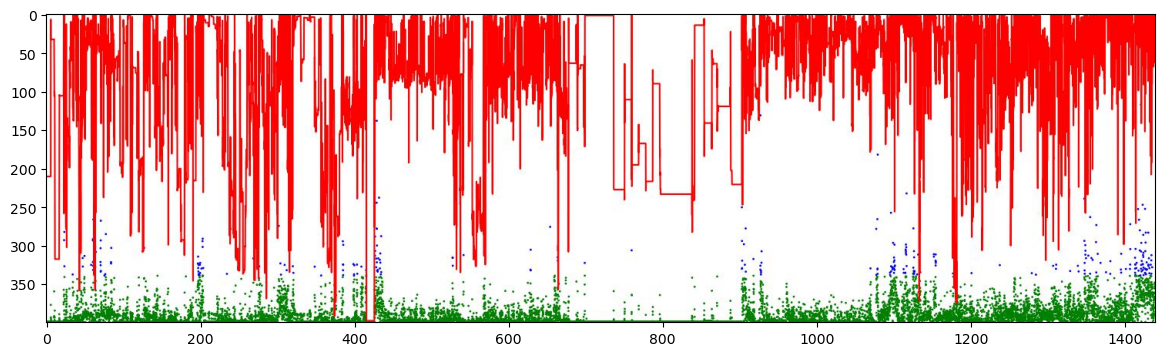

In [49]:
image_name = "137b99e936ab_2018-07-25T20_30_00.jpg"
image_path = os.path.join(processed_data_folder, "images", image_name)
image = read_image(image_path)
plt.figure(figsize=(14.4, 4))
plt.imshow(image.permute(1, 2, 0))

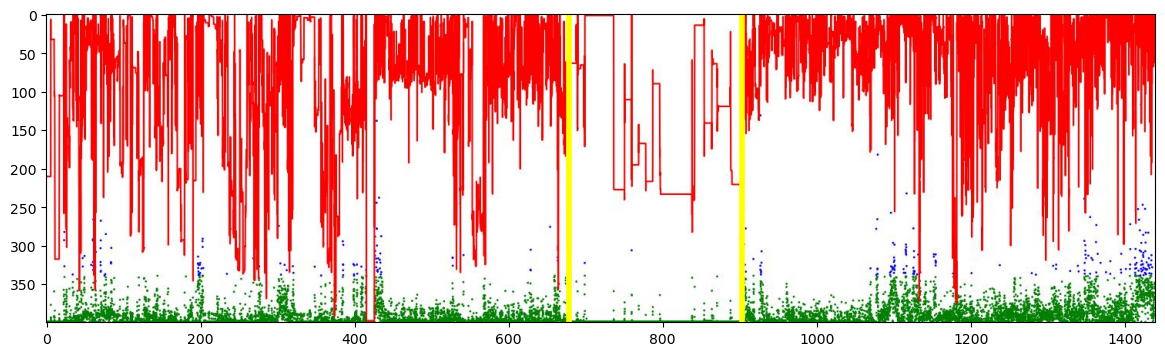

In [50]:
window = annotations_df.loc[annotations_df['image_name'] == image_name].reset_index(drop=True)
window['x'] = (window['x0'] + window['x1']) / 2
plt.figure(figsize=(14.4, 4))
plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(image.permute(1, 2, 0))

In [51]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
predictions

[{'boxes': tensor([[880.1759,  23.1714, 919.7485, 382.4847],
          [674.1035,  27.7298, 712.6598, 374.1299],
          [  3.6175,  24.5245,  43.7085, 385.2978]], device='cuda:0'),
  'labels': tensor([2, 1, 2], device='cuda:0'),
  'scores': tensor([0.8697, 0.4849, 0.4297], device='cuda:0')}]

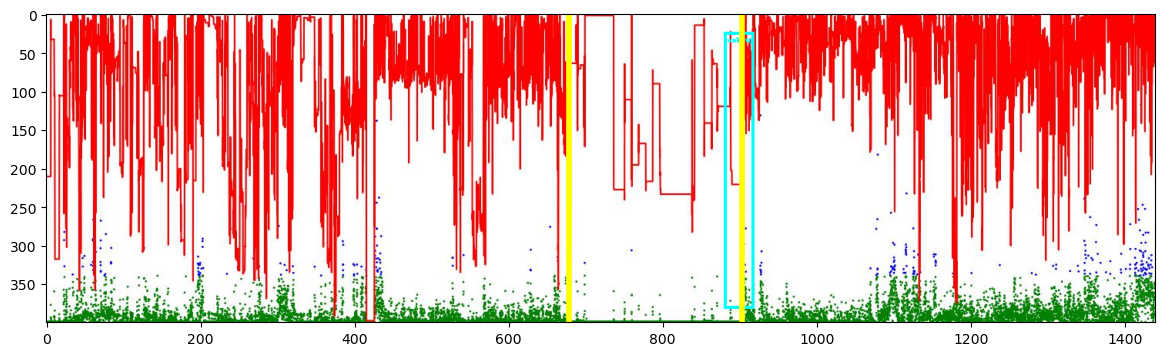

In [52]:
pred = predictions[0]
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="cyan", width=4)
plt.figure(figsize=(14.4, 4))
plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(output_image.permute(1, 2, 0))